<a href="https://colab.research.google.com/github/HAL9K000/wildfires_abound/blob/kh_contrib/Wildfire_Area_Burn_EDA_Analysis_Australia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

In [ ]:
%pip install  nbstripout
!nbstripout EE_API_colab_setup.ipynb
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True \
  --to notebook --inplace EE_API_colab_setup.ipynb

In [2]:
from google.colab import files #Saving files to local directory.
from google.colab import drive #Importing Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
# Installing geetools may be necessary
!pip install earthengine-api geetools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00


## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [3]:
import ee

In [11]:
import numpy as np
import pandas as pan
import random

In [5]:
import geemap
import geetools

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [6]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='erdos-dl-wildfire')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [ ]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


Uploading raster and table assets to Earth Engine.


In [ ]:
!earthengine set_project 'erdos-dl-wildfire'
!earthengine authenticate

E0000 00:00:1751041287.927920    2687 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041287.935089    2687 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Successfully saved project id
E0000 00:00:1751041296.616295    2731 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041296.623750    2731 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0627 16:21:41.134842 136617432432640 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJEC

In [ ]:
tiff_path = r"/content/gdrive/My Drive/Colab Notebooks/GIS/Data/Wildfires/Australia/fire_for16-21.tif"
!earthengine upload image --asset_id="projects/erdos-dl-wildfire/assets/ausfiredata" --pyramiding_policy="mode" $tiff_path

E0000 00:00:1751041481.744401    3823 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751041481.751773    3823 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0627 16:24:46.493137 138022800490496 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
Invalid Cloud Storage URL: /content/gdrive/My


In [ ]:
#
def generate_ROI_mask(country="Australia", state=  None, county=None):
  # Load GAUL level-1 (admin regions like Queensland)
  gaul = ee.FeatureCollection('FAO/GAUL/2015/level0')

  # Filter for {county}, {state}, {country} if they exist.
  filter = [ee.Filter.eq('ADM0_NAME', country)]
  try:
    if county:
            # Use level 2 (county level)
            gaul = ee.FeatureCollection('FAO/GAUL/2015/level2')
            filter.extend([
                ee.Filter.eq('ADM1_NAME', state),
                ee.Filter.eq('ADM2_NAME', county)
            ])
    elif state:
            # Use level 1 (state level)
            gaul = ee.FeatureCollection('FAO/GAUL/2015/level1')
            filter.append(ee.Filter.eq('ADM1_NAME', state))


    qld = gaul.filter(ee.Filter.And(*filter)).geometry()
    return qld
  except Exception as e:
    print(f"Could not find GAUL data for {country}, {state}, {county} with error: {e}")
    return None

In [ ]:
def mask_clouds(image):
    # Use pixel QA band to mask clouds, shadows, snow and water
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(  # Cloud
                 qa.bitwiseAnd(1 << 4).eq(0)).And(      # Shadow
                 qa.bitwiseAnd(1 << 5).eq(0)).And(          # Snow
                 qa.bitwiseAnd(1 << 7).eq(0)        #Water
                 )
    return image.updateMask(cloud_mask)

def compute_nbr(image):
    # NBR = (NIR - SWIR2) / (NIR + SWIR2)
    # Using Landsat 8 Collection 2 band names
    nbr = image.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')
    return image.addBands(nbr)

```calculate_burn_statistics(...)``` Returns Pandas Dataframe of burnt area stats.

In [ ]:
"""
Calculate burn area statistics and return as pandas DataFrame.

Args:
    burn_area: Binary burn area image
    region: Region geometry
    year_pair: Year pair string (e.g., '2019-2020')
    burn_threshold: Burn threshold used
    composite_method: Composite method used

Returns:
    pan.DataFrame: Burn statistics with columns for easy analysis
"""

def calculate_burn_statistics(burn_area, ROI: ee.Geometry, year_pair: str, burn_threshold=0.3,composite_method="mean"):

    # Calculate area in hectares
    area_image = burn_area.multiply(ee.Image.pixelArea()).divide(10000)  # Convert to hectares

    # Sum the burned area
    burn_area_result = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=ROI,
        scale=30,  # Landsat pixel size
        maxPixels=1e9, bestEffort=True
    )

    # Get region total area for percentage calculation
    total_area_result = ee.Image(1).multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=ROI,
        scale=30,
        maxPixels=1e9, bestEffort=True
    )

    # Extract values (these are still ee.ComputedObject at this point)
    #with ee.geetools.Profiler() as p1:
    #if burn_area_result is not None or total_area_result is not None:
    '''
    try:
        # Get the actual values from Earth Engine
        print("Attempting to calculate burnt area stats")
        with ee.geetools.Profiler() as p1:
          burn_area_ha = burn_area_result.getInfo()
        df = pan.DataFrame(p1.profile); print(df.head()); print(df.tail()); print(df.shape); print(df.info()); print(df.describe())

        # Get the actual values from Earth Engine
        print("Attempting to calculate total area stats")
        with ee.geetools.Profiler() as p2:
          total_area_ha = total_area_result.getInfo()
        df = pan.DataFrame(p2.profile); print(df.head()); print(df.tail()); print(df.shape); print(df.info()); print(df.describe())

        # Extract the actual numeric values
        burn_area_value = list(burn_area_ha.values())[0] if burn_area_ha else 0
        total_area_value = list(total_area_ha.values())[0] if total_area_ha else 0

        # Calculate percentage
        burn_percentage = (burn_area_value / total_area_value * 100) if total_area_value > 0 else 0

    except Exception as e:
        print(f"Warning: Could not retrieve burn statistics for {year_pair}: {e}")
        burn_area_value = np.nan
        total_area_value = np.nan
        burn_percentage = np.nan
    #df = pan.DataFrame(p.profile)
    #df.head()
    '''

    # Create DataFrame
    stats_df = pan.DataFrame({
        'year_pair': [year_pair],
    #    'burn_area_ha': [burn_area_value],
    #    'total_area_ha': [total_area_value],
    #    'burn_percentage': [burn_percentage],
        'burn_threshold': [burn_threshold],
        'composite_method': [composite_method]
    })

    return stats_df

In [ ]:
def pairwise_year_dNBR(ROI: ee.Geometry, start_year: int =2019, end_year: int=2020,
          wet_season_months: list = [3, 5], dry_season_months: list = [10, 12]):

    pre_fire_start = f'{start_year}-{wet_season_months[0]:02d}-01'
    pre_fire_end = f'{start_year}-{wet_season_months[1]:02d}-01'
    post_fire_start = f'{end_year}-{wet_season_months[0]:02d}-01'
    post_fire_end = f'{end_year}-{wet_season_months[1]:02d}-01'

    landsat_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

    try:
      pre_fire_img = (landsat_sr.filterBounds(ROI)
                          .filterDate(pre_fire_start, pre_fire_end)
                          .map(mask_clouds)
                          .map(compute_nbr)
                          .median()
                          .clip(ROI))

      post_fire_img = (landsat_sr.filterBounds(ROI)
                           .filterDate(post_fire_start, post_fire_end)
                           .map(mask_clouds)
                           .map(compute_nbr)
                           .median()
                           .clip(ROI))

      # Compute dNBR
      dnbr = pre_fire_img.select('NBR').subtract(post_fire_img.select('NBR')).rename('dNBR')

      # Add year metadata
      dnbr = dnbr.set({
          'year_pair': f'{start_year}-{end_year}',
          'pre_fire_year': start_year,
          'post_fire_year': end_year
      })

      return dnbr
    except Exception as e:
      print(f"Could not compute dNBR for {start_year}-{end_year}, with wet seasons: {wet_season_months} with error: {e}")
      return None

In [ ]:
"""
Perform multi-year burn area analysis and return results as DataFrame.

Args:
    country: Country name
    state: State/province name (optional)
    county: County name (optional)
    years: List of years to analyze (consecutive pairs will be used)
    wet_season_months: Tuple of (start_month, end_month) for wet season
    composite_method: Method for compositing multiple years ('mean', 'median', 'max', 'sum')
    burn_threshold: dNBR threshold for burn classification

Returns:
    pan.DataFrame: Analysis results with burn statistics and metadata
"""

def analyze_multiyear_burns(country="Australia", state = "Queensland", county = None,
                           years= [2013, 2025], wet_season_months= (3, 5),
                           composite_method= 'mean', burn_threshold = 0.1):


    if len(years) < 2:
        raise ValueError("At least 2 years are required for analysis")

    # Get region geometry
    region = generate_ROI_mask(country, state, county)

    # Process year pairs and collect statistics
    all_stats = []
    dnbr_images = []

    for i in range(len(years) - 1):
        year1, year2 = years[i], years[i + 1]
        year_pair = f'{year1}-{year2}'

        # Process year pair
        dnbr = pairwise_year_dNBR(region, year1, year2, wet_season_months)
        if dnbr is not None:
          dnbr_images.append(dnbr)
          # Calculate individual year pair burn statistics
          individual_burn_area = dnbr.gt(burn_threshold).selfMask()

          year_stats = calculate_burn_statistics(individual_burn_area, region, year_pair, burn_threshold, 'individual')
          all_stats.append(year_stats)

          print(f"Processed year pair: {year1}-{year2}")
        else:
          print(f"Skipping year pair: {year1}-{year2} due to missing data")

    # Create composite image
    dnbr_collection = ee.ImageCollection(dnbr_images)

    if composite_method == 'mean':
        composite_dnbr = dnbr_collection.mean().rename('dNBR_composite')
    elif composite_method == 'median':
        composite_dnbr = dnbr_collection.median().rename('dNBR_composite')
    elif composite_method == 'max':
        composite_dnbr = dnbr_collection.max().rename('dNBR_composite')
    elif composite_method == 'sum':
        composite_dnbr = dnbr_collection.sum().rename('dNBR_composite')
    else:
        raise ValueError(f"Unknown composite method: {composite_method}")

    # Apply burn threshold to composite
    composite_burn_area = composite_dnbr.gt(burn_threshold).selfMask()

    # Calculate composite statistics
    composite_stats = calculate_burn_statistics(composite_burn_area, region, 'composite', burn_threshold, composite_method)
    all_stats.append(composite_stats)

    # Combine all statistics
    results_df = pan.concat(all_stats, ignore_index=True) #pan.DataFrame() #pan.concat(all_stats, ignore_index=True)

    # Add metadata columns
    results_df['country'] = country
    results_df['state'] = state
    results_df['county'] = county
    results_df['years_analyzed'] = str(years)
    results_df['wet_season_start'] = wet_season_months[0]
    results_df['wet_season_end'] = wet_season_months[1]

    #results_df['analysis_timestamp'] = pan.Timestamp.now()

    # Store the Earth Engine objects for visualization
    results_df.attrs['composite_dnbr'] = composite_dnbr
    results_df
    results_df.attrs['composite_burn_area'] = composite_burn_area
    results_df.attrs['region'] = region

    print(results_df)

    return results_df

In [7]:
"""
Creates an interactive map visualization of the burn analysis results.

Args:
    results_df: Results DataFrame from analyze_multiyear_burns
    zoom_level: Initial zoom level for the map

Returns:
    geemap.Map: Interactive map with burn analysis layers
"""

def visualize_results(results_df: pan.DataFrame,
                     zoom_level: int = 8) -> geemap.Map:
    # Extract Earth Engine objects from DataFrame attributes
    composite_dnbr = results_df.attrs['composite_dnbr']
    #composite_burn_area = results_df.attrs['composite_burn_area']
    region = results_df.attrs['region']

    # Get metadata from the composite row
    composite_row = results_df[results_df['year_pair'] == 'composite'].iloc[0]

    # Get map center from region centroid
    center = region.centroid(10).coordinates().getInfo()[::-1]

    # Create map
    Map = geemap.Map(center=center, zoom=zoom_level)

    # Add dNBR layer
    dnbr_vis = {
        'min': -0.5,
        'max': 1,
        'palette': "Set2"
    }
    Map.addLayer(composite_dnbr, dnbr_vis,
                f'dNBR Composite ({composite_row["composite_method"]})')

    # Add burn area layer (self mask for dNBR gt 0.1)
    composite_burn_area_1 = composite_dnbr.gt(composite_row['burn_threshold']).selfMask()
    composite_burn_area_2 = composite_dnbr.gt(composite_row['burn_threshold'] + 0.2).selfMask()
    burn_vis = {'palette': 'violetred'}; burn_vis2 = {'palette': 'black'}
    Map.addLayer(composite_burn_area_1, burn_vis,
                f'Burn Area (threshold: {composite_row["burn_threshold"]})')

    Map.addLayer(composite_burn_area_2, burn_vis2,
                f'Burn Area (threshold: {composite_row["burn_threshold"] + 0.15})')

    # Add region boundary
    region_vis = {'color': 'blue', 'fillColor': '00000000', 'width': 2}
    Map.addLayer(region, region_vis, 'Region Boundary')

    # Add layer control
    Map.addLayerControl()

    return Map

def print_burn_summary(results_df: pan.DataFrame):
    """
    Print a summary of burn analysis results.

    Args:
        results_df: Results DataFrame from analyze_multiyear_burns
    """
    print("=== Burn Analysis Summary ===")
    print(f"Country: {results_df['country'].iloc[0]}")
    print(f"State: {results_df['state'].iloc[0] or 'All'}")
    print(f"County: {results_df['county'].iloc[0] or 'All'}")
    print(f"Years: {results_df['years_analyzed'].iloc[0]}")
    print(f"Wet Season: Months {results_df['wet_season_start'].iloc[0]}-{results_df['wet_season_end'].iloc[0]}")
    print()

    # Individual year pairs
    individual_results = results_df[results_df['year_pair'] != 'composite']
    if not individual_results.empty:
        print("Individual Year Pairs:")
        for _, row in individual_results.iterrows():
            print(f"  {row['year_pair']}: {row['burn_area_ha']:.2f} ha ({row['burn_percentage']:.3f}%)")

    # Composite result
    composite_result = results_df[results_df['year_pair'] == 'composite']
    if not composite_result.empty:
        comp_row = composite_result.iloc[0]
        print(f"\nComposite ({comp_row['composite_method']}):")
        print(f"  Total burn area: {comp_row['burn_area_ha']:.2f} ha")
        print(f"  Percentage of region: {comp_row['burn_percentage']:.3f}%")
        print(f"  Burn threshold: {comp_row['burn_threshold']}")


In [ ]:
results_df = analyze_multiyear_burns(
      country='Australia', state='Queensland',
      years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], wet_season_months=(3, 5),
      composite_method='max', burn_threshold=0.1)

#print_burn_summary(results_df)
Map = visualize_results(results_df, zoom_level=6)

Processed year pair: 2014-2015
Processed year pair: 2015-2016
Processed year pair: 2016-2017
Processed year pair: 2017-2018
Processed year pair: 2018-2019
Processed year pair: 2019-2020
Processed year pair: 2020-2021
Processed year pair: 2021-2022
Processed year pair: 2022-2023
Processed year pair: 2023-2024
Processed year pair: 2024-2025
    year_pair  burn_threshold composite_method    country       state county  \
0   2014-2015             0.1       individual  Australia  Queensland   None   
1   2015-2016             0.1       individual  Australia  Queensland   None   
2   2016-2017             0.1       individual  Australia  Queensland   None   
3   2017-2018             0.1       individual  Australia  Queensland   None   
4   2018-2019             0.1       individual  Australia  Queensland   None   
5   2019-2020             0.1       individual  Australia  Queensland   None   
6   2020-2021             0.1       individual  Australia  Queensland   None   
7   2021-2022      

In [ ]:
# Get size of results_df in memory
import sys
print(f"Results DataFrame size: {sys.getsizeof(results_df) / 1e6:.2f} MB")

Results DataFrame size: 0.01 MB


In [ ]:
Map

Map(center=[-22.49617473424894, 144.4597314108364], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo


Number of CPU:  2
processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2249.998
cache size	: 512 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 spec_store_bypass retbleed

In [ ]:
def process_multi_year_burn_analysis(aoi_geometry, years, n_rois_per_year=50,
                                   roi_size=128, export_folder='burn_analysis'):
    """
    Process burn analysis for multiple years with random ROI sampling

    Args:
        aoi_geometry: ee.Geometry for Queensland or study area
        years: List of years to process
        n_rois_per_year: Number of random ROIs to sample per year
        roi_size: Size of ROIs in pixels
        export_folder: Folder name for exports

    Returns:
        List of export tasks
    """
    # Create grid of potential ROI locations
    grid_points = create_grid_points(aoi_geometry, roi_size)
    print(f"Created grid with {len(grid_points)} potential ROI locations")

    # Burn severity thresholds
    burn_thresholds = {
        'unburned': 0.1,
        'low_min': 0.1, 'low_max': 0.27,
        'mod_min': 0.27, 'mod_max': 0.44,
        'high_min': 0.44,
        'burn_threshold': 0.1
    }

    export_tasks = []

    for year in years:
        print(f"Processing year {year}...")

        # Define fire season dates (adjust for Australian fire season)
        pre_fire_start = f"{year-1}-04-01"
        pre_fire_end = f"{year-1}-10-31"
        post_fire_start = f"{year}-01-01"
        post_fire_end = f"{year}-03-31"

        # Create pre and post fire collections
        pre_collection = create_landsat8_collection(pre_fire_start, pre_fire_end, aoi_geometry)
        post_collection = create_landsat8_collection(post_fire_start, post_fire_end, aoi_geometry)

        # Check if collections have images
        pre_count = pre_collection.size().getInfo()
        post_count = post_collection.size().getInfo()

        if pre_count == 0 or post_count == 0:
            print(f"Insufficient data for {year}: pre={pre_count}, post={post_count}")
            continue

        # Create composites
        pre_composite = create_composite_with_indices(pre_collection, 'median')
        post_composite = create_composite_with_indices(post_collection, 'median')

        # Calculate dNBR
        dnbr = calculate_dnbr(pre_composite, post_composite)

        # Create burn severity bands
        burn_bands = create_burn_severity_bands(dnbr, burn_thresholds)
        combined_dnbr = dnbr.addBands(burn_bands)

        # Sample random ROIs for this year
        sampled_rois = sample_random_rois(grid_points, n_rois_per_year, seed=year)

        # Export each ROI
        for i, roi_center in enumerate(sampled_rois):
            roi_geom = create_roi_from_center(roi_center, roi_size)

            export_params = {
                'description': f'burn_roi_{year}_{i:03d}',
                'filename': f'burn_roi_{year}_{i:03d}',
                'folder': export_folder,
                'scale': 30,
                'max_pixels': 1e9,
                'bands': [
                    'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7',
                    'NDVI', 'NBR', 'dNBR',
                    'burn_mask', 'low_severity', 'moderate_severity', 'high_severity'
                ]
            }

            # Use post-fire composite as base (contains all spectral info)
            task = export_roi_data(roi_geom, post_composite, combined_dnbr, export_params)
            export_tasks.append(task)

            # Start the export task
            task.start()
            print(f"Started export for ROI {i+1}/{n_rois_per_year} in {year}")

    return export_tasks

In [12]:
def create_grid_points(ROI, ROI_size=128, pixel_size=30, spacing_factor=1.0):
    """
    Create a regular grid of potential ROI centers within the AOI

    Args:
        ROI: ee.Geometry for the area of interest
        ROI_size: Size of each ROI in pixels (default: 128)
        pixel_size: Pixel resolution in meters (default: 30m)
        spacing_factor: Factor to control grid spacing (1.0 = no overlap)

    Returns:
        List of [lon, lat] coordinates for grid centers
    """
    # Get bounds of the AOI
    bounds = ROI.bounds()
    coords = bounds.coordinates().get(0).getInfo()

    # Calculate bounding box
    lons = [coord[0] for coord in coords]
    lats = [coord[1] for coord in coords]
    min_lon, max_lon = min(lons), max(lons)
    min_lat, max_lat = min(lats), max(lats); midlat = (min_lat + max_lat) / 2

    # Convert ROI size from meters to degrees (approximate)
    ROI_size_meters = ROI_size * pixel_size
    ROI_size_deg_lat = ROI_size_meters / (111132.954 * np.cos(np.radians((midlat))) - 559.822 * np.cos(np.radians(2.0 * midlat )))
    ROI_size_deg_lon = ROI_size_meters / (((np.pi/180)*(6367449)) * np.cos(np.radians(midlat)))
    # Length of a degree: https://en.wikipedia.org/wiki/Geographic_coordinate_system#Latitude_and_longitude

    # Calculate grid spacing
    grid_spacing_lon = ROI_size_deg_lon * spacing_factor
    grid_spacing_lat = ROI_size_deg_lat * spacing_factor

    # Generate grid points
    grid_points = []
    lat = min_lat + ROI_size_deg_lat / 2
    while lat < max_lat - ROI_size_deg_lat / 2:
        lon = min_lon + ROI_size_deg_lon / 2
        while lon < max_lon - ROI_size_deg_lon / 2:
            point = ee.Geometry.Point([lon, lat])
            # Check if point is within AOI
            if ROI.contains(point).getInfo():
                grid_points.append([lon, lat])
            lon += grid_spacing_lon
        lat += grid_spacing_lat

    return grid_points

def create_ROI_from_center(center_coords, roi_size=128, pixel_size=30):
    """
    Create a square ROI geometry from center coordinates

    Args:
        center_coords: [lon, lat] coordinates of ROI center
        roi_size: Size of ROI in pixels
        pixel_size: Pixel resolution in meters

    Returns:
        ee.Geometry.Rectangle for the ROI
    """
    lon, lat = center_coords
    ROI_size_meters = roi_size * pixel_size

    # Convert to degrees
    ROI_half_deg_lat = 0.5*ROI_size_meters / (111132.954 * np.cos(np.radians((midlat))) - 559.822 * np.cos(np.radians(2.0 * midlat )))
    ROI_half_deg_lon = 0.5*ROI_size_meters / (((np.pi/180)*(6367449)) * np.cos(np.radians(midlat)))

    # Create rectangle
    return ee.Geometry.Rectangle([
        lon - ROI_half_deg_lon,
        lat - ROI_half_deg_lat,
        lon + ROI_half_deg_lon,
        lat + ROI_half_deg_lat
    ])

def sample_random_ROIS(grid_points, n_samples, seed= np.random.seed()):
    """
    Randomly sample ROI centers from grid points

    Args:
        grid_points: List of [lon, lat] coordinates
        n_samples: Number of ROIs to sample
        seed: Random seed for reproducibility

    Returns:
        List of sampled [lon, lat] coordinates
    """
    random.seed(seed)
    return random.sample(grid_points, min(n_samples, len(grid_points)))



In [13]:
def create_landsat8_collection(start_date, end_date, aoi):
    """
    Create a Landsat 8 collection with cloud masking

    Args:
        start_date: Start date string (YYYY-MM-DD)
        end_date: End date string (YYYY-MM-DD)
        aoi: Area of interest geometry

    Returns:
        ee.ImageCollection with cloud-masked Landsat 8 images
    """
    def mask_clouds(image):
        qa = image.select('QA_PIXEL')
        # Mask clouds and cloud shadows
        cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))
        return image.updateMask(cloud_mask)

    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .map(mask_clouds)

    return collection

def calculate_spectral_indices(image):
    """
    Calculate spectral indices (NDVI, NBR, etc.) for a Landsat 8 image

    Args:
        image: ee.Image (Landsat 8)

    Returns:
        ee.Image with added spectral index bands
    """
    # Scale factors for Landsat 8 Collection 2
    # Taken from: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products
    def apply_scale_factors(img):
        optical_bands = img.select('SR_B.').multiply(0.0000275).add(-0.2)
        thermal_bands = img.select('ST_B.*').multiply(0.00341802).add(149.0)
        return img.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

    scaled = apply_scale_factors(image)

    # Calculate NDVI
    ndvi = scaled.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # Calculate NBR (Normalized Burn Ratio)
    nbr = scaled.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')


    # Add date band
    date_band = ee.Image.constant(image.date().millis()).rename('date')

    return scaled.addBands([ndvi, nbr, date_band])


def calculate_spectral_indices_with_timestamp(image):
    """
    Calculate spectral indices and add timestamp information
    """
    # Scale factors for Landsat 8 Collection 2
    def apply_scale_factors(img):
        optical_bands = img.select('SR_B.').multiply(0.0000275).add(-0.2)
        thermal_bands = img.select('ST_B.*').multiply(0.00341802).add(149.0)
        return img.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

    scaled = apply_scale_factors(image)

    # Calculate NDVI
    ndvi = scaled.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    # Calculate NBR (Normalized Burn Ratio)
    nbr = scaled.normalizedDifference(['SR_B5', 'SR_B7']).rename('NBR')

    # Add timestamp information
    date = ee.Date(image.get('system:time_start'))
    timestamp = date.millis().divide(1000)  # Unix timestamp in seconds
    day_of_year = date.getRelative('day', 'year').add(1)
    year = date.get('year')

    # Create timestamp bands
    timestamp_band = ee.Image.constant(timestamp).rename('timestamp').int64()
    doy_band = ee.Image.constant(day_of_year).rename('day_of_year').int16()
    year_band = ee.Image.constant(year).rename('year').int16()

    # Preserve original metadata
    return scaled.addBands([ndvi, nbr, timestamp_band, doy_band, year_band]) \
                 .copyProperties(image, ['system:time_start', 'system:id', 'CLOUD_COVER'])

In [15]:
def create_composite_with_indices(collection, composite_method='max'):
    """
    Create composite image with spectral indices

    Args:
        collection: ee.ImageCollection of Landsat images
        composite_method: Method for compositing ('max', 'median', 'mean')

    Returns:
        ee.Image composite with spectral indices
    """
    # Add spectral indices to all images
    collection_with_indices = collection.map(calculate_spectral_indices)

    # Create composite
    if composite_method == 'max':
        composite = collection_with_indices.max()
    elif composite_method == 'median':
        composite = collection_with_indices.median()
    elif composite_method == 'mean':
        composite = collection_with_indices.mean()
    else:
        composite = collection_with_indices.median()  # default

    # Add composite-specific metadata
    composite_timestamp = ee.Image.constant(-1).rename('timestamp').int64()  # Special value for yearly composite
    composite_type = ee.Image.constant(1).rename('is_composite').int8()  # Flag for composite

    return composite.addBands([composite_timestamp, composite_type], None, True)

    return composite

def calculate_dnbr(pre_fire_composite, post_fire_composite):
    """
    Calculate difference Normalized Burn Ratio (dNBR)

    Args:
        pre_fire_composite: ee.Image composite before fire
        post_fire_composite: ee.Image composite after fire

    Returns:
        ee.Image with dNBR band
    """
    pre_nbr = pre_fire_composite.select('NBR')
    post_nbr = post_fire_composite.select('NBR')
    dnbr = pre_nbr.subtract(post_nbr).rename('dNBR')
    return dnbr



def export_roi_data(roi_geometry, composite_image, dnbr_image, export_params):
    """
    Export multi-channel data for a single ROI

    Args:
        roi_geometry: ee.Geometry for the ROI
        composite_image: ee.Image with spectral bands and indices
        dnbr_image: ee.Image with dNBR and burn severity bands
        export_params: Dictionary with export parameters

    Returns:
        ee.batch.Task export task
    """
    # Combine all bands
    export_image = composite_image.addBands(dnbr_image)

    # Select desired bands
    bands_to_export = export_params.get('bands', [
        'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7',  # Landsat bands
        'NDVI', 'NBR', 'dNBR',  # Spectral indices
        'burn_mask', 'low_severity', 'moderate_severity', 'high_severity'  # Burn severity
    ])

    final_image = export_image.select(bands_to_export)

    # Export parameters
    task = ee.batch.Export.image.toDrive(
        image=final_image,
        description=export_params['description'],
        folder=export_params.get('folder', 'GEE_exports'),
        fileNamePrefix=export_params['filename'],
        region=roi_geometry,
        scale=export_params.get('scale', 30),
        crs=export_params.get('crs', 'EPSG:4326'),
        maxPixels=export_params.get('max_pixels', 1e9),
        fileFormat='GeoTIFF'
    )

    return task



In [18]:
def pairwise_year_calcdNBR(ROI: ee.Geometry, pre_fire_composite: ee.Image, post_fire_composite: ee.Image, thresholds, start_year: int, end_year:int):

    """
    Calculate difference Normalized Burn Ratio (dNBR)

    Args:
        pre_fire_composite: ee.Image composite before fire
        post_fire_composite: ee.Image composite after fire

    Returns:
        ee.Image with dNBR band
    """
    pre_nbr = pre_fire_composite.select('NBR')
    post_nbr = post_fire_composite.select('NBR')
    dnbr = pre_nbr.subtract(post_nbr).rename('dNBR')

    # Create severity bands based on thresholds
    unburned = dnbr.lt(thresholds.get('unburned', 0.1)).rename('unburned')
    low_severity = dnbr.gte(thresholds.get('low_min', 0.1)).And(
        dnbr.lt(thresholds.get('low_max', 0.25))).rename('low_severity')
    moderate_severity = dnbr.gte(thresholds.get('mod_min', 0.25)).And(
        dnbr.lt(thresholds.get('mod_max', 0.5))).rename('moderate_severity')
    high_severity = dnbr.gte(thresholds.get('high_min', 0.5)).rename('high_severity')

    composite_timestamp = ee.Image.constant(-888).rename('timestamp').int64()  # Special value for dNBR
    composite_type = ee.Image.constant(2).rename('is_composite').int8()  # Flag for dNBR composite

    # Add year metadata
    #dnbr = dnbr.set({
    #      'year_pair': f'{start_year}-{end_year}',
    #      'pre_fire_year': start_year,
    #      'post_fire_year': end_year
    #})

    # Create binary burn mask
    burn_mask = dnbr.gt(thresholds.get('burn_threshold', 0.1)).rename('burn_mask')


    return ee.Image.cat([dnbr, burn_mask, unburned, low_severity, moderate_severity, high_severity,
        composite_timestamp, composite_type])

def create_burn_severity_bands(dnbr_image, thresholds):
    """
    Create burn severity classification bands

    Args:
        dnbr_image: ee.Image with dNBR band
        thresholds: Dictionary with severity thresholds

    Returns:
        ee.Image with burn severity bands
    """
    dnbr = dnbr_image.select('dNBR')

    # Create severity bands based on thresholds
    unburned = dnbr.lt(thresholds.get('unburned', 0.1)).rename('unburned')
    low_severity = dnbr.gte(thresholds.get('low_min', 0.1)).And(
        dnbr.lt(thresholds.get('low_max', 0.25))).rename('low_severity')
    moderate_severity = dnbr.gte(thresholds.get('mod_min', 0.25)).And(
        dnbr.lt(thresholds.get('mod_max', 0.5))).rename('moderate_severity')
    high_severity = dnbr.gte(thresholds.get('high_min', 0.5)).rename('high_severity')

    # Create binary burn mask
    burn_mask = dnbr.gt(thresholds.get('burn_threshold', 0.1)).rename('burn_mask')

    return ee.Image.cat([unburned, low_severity, moderate_severity, high_severity, burn_mask])

In [19]:
def export_time_series_for_roi(roi_geometry, roi_id, year_data, export_folder):
    """
    Export time series data for a single ROI

    Args:
        roi_geometry: ee.Geometry for the ROI
        roi_id: Unique identifier for the ROI
        year_data: Dictionary containing collections and composites for the year
        export_folder: Base folder for exports

    Returns:
        List of export tasks
    """
    tasks = []
    year = year_data['year']

    # Define bands to export for regular images
    landsat_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    index_bands = ['NDVI', 'NBR']
    metadata_bands = ['timestamp', 'day_of_year', 'year', 'is_composite']
    regular_bands = landsat_bands + index_bands + metadata_bands

    # Export individual images from collections
    collections_to_export = [
        ('pre_fire', year_data['pre_fire_collection']),
        ('post_fire', year_data['post_fire_collection'])
    ]

    for period, collection in collections_to_export:
        # Convert collection to list for individual exports
        collection_list = collection.toList(collection.size())
        collection_size = collection.size().getInfo()

        for i in range(collection_size):
            image = ee.Image(collection_list.get(i))

            # Get image date for filename
            date_str = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

            export_params = {
                'image': image.select(regular_bands),
                'description': f'roi_{roi_id:03d}_{year}_{period}_{date_str}_{i:02d}',
                'folder': f'{export_folder}/roi_{roi_id:03d}',
                'fileNamePrefix': f'roi_{roi_id:03d}_{year}_{period}_{date_str}_{i:02d}',
                'region': roi_geometry,
                'scale': 30,
                'crs': 'EPSG:4326',
                'maxPixels': 1e9,
                'fileFormat': 'GeoTIFF'
            }

            task = ee.batch.Export.image.toDrive(**export_params)
            tasks.append(task)

    # Export composites (pre-fire, post-fire, and dNBR)
    composite_exports = [
        ('pre_composite', year_data['pre_composite'], regular_bands),
        ('post_composite', year_data['post_composite'], regular_bands),
        ('dnbr_composite', year_data['dnbr_composite'],
         ['dNBR', 'burn_mask', 'unburned', 'low_severity', 'moderate_severity',
          'high_severity', 'timestamp', 'is_composite'])
    ]

    for comp_name, composite, bands in composite_exports:
        export_params = {
            'image': composite.select(bands),
            'description': f'roi_{roi_id:03d}_{year}_{comp_name}',
            'folder': f'{export_folder}/roi_{roi_id:03d}',
            'fileNamePrefix': f'roi_{roi_id:03d}_{year}_{comp_name}',
            'region': roi_geometry,
            'scale': 30,
            'crs': 'EPSG:4326',
            'maxPixels': 1e9,
            'fileFormat': 'GeoTIFF'
        }

        task = ee.batch.Export.image.toDrive(**export_params)
        tasks.append(task)

    return tasks


def process_multi_year_burn_analysis(country="Australia", state = "Queensland", county = None,
                           years= [2013, 2025], wet_season_months= (3, 5),
                           composite_method= 'max', n_rois_samples=100,
                            ROI_size=128, export_folder='burn_analysis'):
    """
    Process burn analysis for multiple years with random ROI sampling

    Args:
        aoi_geometry: ee.Geometry for Queensland or study area
        years: List of years to process
        n_rois_per_year: Number of random ROIs to sample per year
        roi_size: Size of ROIs in pixels
        export_folder: Folder name for exports

    Returns:
        List of export tasks
    """

    if len(years) < 2:
        raise ValueError("At least 2 years are required for analysis")

    # Get region geometry
    region = generate_ROI_mask(country, state, county)
    # Create grid of potential ROI locations
    grid_points = create_grid_points(region, ROI_size, 30, 1.0 + 1e-5)
    print(f"Created grid with {len(grid_points)} potential ROI locations")

    # Sample random ROIs across years
    sampled_rois = sample_random_ROIS(grid_points, n_rois_samples)

    # Burn severity thresholds
    burn_thresholds = {
        'unburned': 0.1,
        'low_min': 0.1, 'low_max': 0.25,
        'mod_min': 0.25, 'mod_max': 0.5,
        'high_min': 0.5,
        'burn_threshold': 0.1
    }

    landsat_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    all_dNBR_composites =[]
    all_tasks = [];

    for i in range(len(years) - 1):
        year1, year2 = years[i], years[i + 1]
        year_pair = f'{year1}-{year2}'

        # Define wet season dates (adjust for Australian fire season)
        pre_fire_start = f'{year1}-{wet_season_months[0]:02d}-01'
        pre_fire_end = f'{year1}-{wet_season_months[1]:02d}-01'
        post_fire_start = f'{year2}-{wet_season_months[0]:02d}-01'
        post_fire_end = f'{year2}-{wet_season_months[1]:02d}-01'



        # Create pre and post fire collections
        try:
          pre_fire_imgcollection = (landsat_sr.filterBounds(region)
                          .filterDate(pre_fire_start, pre_fire_end)
                          .map(mask_clouds)
                          .map(compute_nbr)
                          .median()
                          .clip(region))

          post_fire_imgcollection = (landsat_sr.filterBounds(region)
                           .filterDate(post_fire_start, post_fire_end)
                           .map(mask_clouds)
                           .map(compute_nbr)
                           .median()
                           .clip(region))

          all_year_imgcollections= (landsat_sr.filterBounds(region)
                           .filterDate(pre_fire_end, post_fire_end)
                           .map(mask_clouds)
                           .map(compute_nbr)
                           .median()
                           .clip(region))
        except Exception as e:
          print(f"Could not create collections for {year_pair}, with wet seasons: {wet_season_months} with error: {e}")
          continue

        pre_collection_with_indices = pre_fire_imgcollection.map(calculate_spectral_indices_with_timestamp)
        post_collection_with_indices = post_fire_imgcollection.map(calculate_spectral_indices_with_timestamp)
        all_year_collection_with_indices = all_year_imgcollections.map(calculate_spectral_indices_with_timestamp)

        # Check if collections have images
        pre_count = pre_fire_imgcollection.size().getInfo()
        post_count = post_fire_imgcollection.size().getInfo()
        all_year_count = all_year_imgcollections.size().getInfo()

        if pre_count == 0 or post_count == 0 or all_year_count == 0:
            print(f"Insufficient data for {year_pair}: pre={pre_count}, post={post_count}, all-year={all_year_count}")
            print("Maybe choose a less restrictive wet season range?")
            continue
        #pre_collection = create_landsat8_collection(pre_fire_start, pre_fire_end, aoi_geometry)
        #post_collection = create_landsat8_collection(post_fire_start, post_fire_end, aoi_geometry)
        print(f"For the years: {year_pair}, found {pre_count} pre-fire, {post_count} post-fire and {all_year_count} total images...")


        # Create composites with timestamp metadata
        pre_composite = create_composite_with_indices(pre_fire_imgcollection, composite_method)
        post_composite = create_composite_with_indices(post_fire_imgcollection, composite_method)


        # Calculate dNBR with timestamp metadata
        dNBR_composite = pairwise_year_calcdNBR(region, pre_composite, post_composite, year1, year2)

        # Create burn severity bands
        burn_bands = create_burn_severity_bands(dNBR_composite, burn_thresholds)
        combined_dNBR_composite = dnbr.addBands(burn_bands)

        all_dNBR_composites.append(combined_dNBR_composite)

        # Prepare yearly data
        year_data = {
            'year': year,
            'pre_fire_collection': pre_collection_with_indices,
            'post_fire_collection': post_collection_with_indices,
            'all_year_collection': all_year_collection_with_indices,
            'pre_composite': pre_composite,
            'post_composite': post_composite,
            'dnbr_composite': dnbr_composite,
            'pre_count': pre_count,
            'post_count': post_count,
            'all_year_count': all_year_count
        }

        # Export data for each ROI
        year_tasks = []
        for roi_id, roi_geom in enumerate(sampled_rois):
            print(f"  Processing ROI {roi_id+1}/{len(sampled_rois)}...")

            roi_tasks = export_time_series_for_roi(roi_geom, roi_id, year_data, export_folder)
            year_tasks.extend(roi_tasks)

            # Start tasks in batches to avoid overwhelming the system
            for task in roi_tasks:
                task.start()

        all_tasks.extend(year_tasks)

        # Store export metadata
        metadata['export_info'].append({
            'year': year1,
            'year_pair': year_pair,
            'pre_fire_images': pre_count,
            'post_fire_images': post_count,
            'all_year_images': all_year_count,
            'total_exports_per_roi': pre_count + post_count + all_year_count + 3,  # +3 for composites
            'tasks_started': len(year_tasks)
        })

        print(f"Started {len(year_tasks)} export tasks for {year}")

    print(f"\nTotal export tasks started: {len(all_tasks)}")

    # Finally create a composite of dNBR composites (for visualisation)
    composed_dNBR_composite = ee.ImageCollection(all_dNBR_composites)
    if composite_method == 'max':
        composed_dNBR_composite = composed_dNBR_composite.max()
    elif composite_method == 'median':
        composed_dNBR_composite = composed_dNBR_composite.median()
    elif composite_method == 'mean':
        composed_dNBR_composite = composed_dNBR_composite.mean()
    elif composite_method == 'sum':
        composed_dNBR_composite = composed_dNBR_composite.sum()
    elif composite_method == 'min':
        composed_dNBR_composite = composed_dNBR_composite.min()
    else:
        raise ValueError(f"Unknown composite method: {composite_method}")

    return {'tasks': all_tasks,'metadata': metadata}, composed_dNBR_composite, grid_points, sampled_rois

SyntaxError: invalid syntax (ipython-input-19-2100966248.py, line 207)

In [ ]:
def create_roi_visualization(aoi_geometry, fixed_roi_centers, sampled_roi_centers, dnbr_composite=None):
    """
    Create visualization of fixed ROI locations
    """
    Map = geemap.Map()

    # Add dNBR composite if provided
    if dnbr_composite:
        dnbr_vis = {
            'min': -0.2,
            'max': 0.8,
            'palette': 'Set2'
        }
        Map.addLayer(dnbr_composite.select('dNBR'), dnbr_vis, 'dNBR Composite')
        Map.addLayer(dnbr_composite.select('burn_mask'),
                    {'palette': ['transparent', 'violetred', 'indianred', 'black']}, 'Burn Areas', opacity=0.6)

    # Add Fixed ROI grid
    roi_geometries = [create_ROI_from_center(center, 128, 30) for center in fixed_roi_centers]
    roi_features = [ee.Feature(geom, {'roi_id': i}) for i, geom in enumerate(roi_geometries)]
    roi_collection = ee.FeatureCollection(roi_features)

    roi_style = {
        'color': 'cyan',
        'fillColor': 'transparent',
        'width': 2
    }
    Map.addLayer(roi_collection.style(**roi_style), {}, 'Fixed ROI Grid')

    # Add sampled ROI grids
    sampled_roi_geometries = [create_ROI_from_center(center, 128, 30) for center in sampled_roi_centers]
    sampled_roi_features = [ee.Feature(geom, {'roi_id': i}) for i, geom in enumerate(sampled_roi_geometries)]
    sampled_roi_collection = ee.FeatureCollection(sampled_roi_features)

    sampled_roi_style = {
        'color': 'indigo',
        'fillColor': 'cornflowerblue',
        'width': 2
        'opacity': 0.85
    }
    Map.addLayer(sampled_roi_collection.style(**sampled_roi_style), {}, 'Sampled ROI Grid')

    # Center on AOI
    Map.centerObject(aoi_geometry, 8)
    Map.add_layer_control()
    Map.add_scale_bar()

    return Map

In [ ]:
export_taskdata, composed_dNBR_composite, grid_ROIC, sampled_ROIC = analyze_multiyear_burns(country='Australia', state='Queensland',
      years=[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025], wet_season_months=(3, 5),
      composite_method='max', n_rois_samples=100, ROI_size=128, export_folder='burn_analysis')



In [ ]:
region = generate_ROI_mask(country='Australia', state='Queensland')
vis_map = create_roi_visualization(region, grid_ROIC, sampled_ROIC ,  composed_dNBR_composite)
display(vis_map)

In [ ]:
tasks = export_taskdata['tasks']
metadata = export_taskdata['metadata']

print(f"Export metadata:")
print(f"Total ROIs: {metadata['n_rois']}")
print(f"Years: {metadata['years']}")
print(f"Total tasks: {len(tasks)}")

# Check task status
for i, task in enumerate(tasks[:10]):  # Check first 10 tasks
    print(f"Task {i}: {task.config['description']} - {task.status()}")

OLD CODE

In [ ]:


pre_fire = ('2019-03-01', '2019-04-01')
post_fire = ('2020-03-01', '2020-04-01') # Corrected end date



# Load and filter Landsat 8 SR images (Tier 1) - Changed to Collection 2 Surface Reflectance
landsat_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
#print(landsat_sr)

pre_fire_img = (landsat_sr.filterBounds(queens_AOI)
                          .filterDate(*pre_fire)
                          .map(mask_clouds)
                          .map(compute_nbr)
                          .median()
                          .clip(queens_AOI))

post_fire_img = (landsat_sr.filterBounds(queens_AOI)
                           .filterDate(*post_fire)
                           .map(mask_clouds)
                           .map(compute_nbr)
                           .median()
                           .clip(queens_AOI))

# Compute dNBR
dnbr = pre_fire_img.select('NBR').subtract(post_fire_img.select('NBR')).rename('dNBR')

# Define burn threshold (0.1 to 0.3 = low severity, >0.3 = high severity)
burn_area = dnbr.gt(0.1).selfMask()

# Optional: visualize using geemap
Map = geemap.Map(center=queens_AOI.centroid(10).coordinates().getInfo()[::-1], zoom=10)
Map.addLayer(dnbr, {'min': -0.5, 'max': 1, 'palette': ['white', 'yellow', 'orange', 'red']}, 'dNBR')
Map.addLayer(burn_area, {'palette': 'black'}, 'Burned Area')
Map.addLayerControl()
Map

Map(center=[-22.49617473426755, 144.45973141082249], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
  gaul = ee.FeatureCollection('FAO/GAUL/2015/level2')
  qld = gaul.filter(ee.Filter.And(
      ee.Filter.eq('ADM0_NAME', 'Australia'),
      ee.Filter.eq('ADM1_NAME', 'Queensland')
  )).geometry()

  queens_AOI = qld

## Map visualization

`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.


### Static image

The `IPython.display` module contains the `Image` function, which can display
the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail
of the global elevation model.

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

### Interactive map

The [geemap](https://github.com/gee-community/geemap)
library can be used to display `ee.Image` objects on an interactive
[ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) map.

The following cell provides an example of using the `geemap.Map` object to
display an elevation model.

In [ ]:
# Import the geemap library.
import geemap

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a map object.
m = geemap.Map(center=[20, 0], zoom=3)

# Add the elevation model to the map object.
m.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Display the map.
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

## Chart visualization

Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

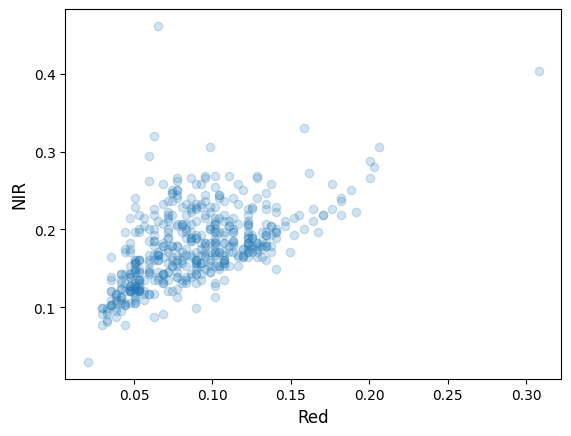

In [ ]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat TOA image.
img = ee.Image('LANDSAT/LT05/C02/T1_TOA/LT05_034033_20000913')

# Select Red and NIR bands and sample 500 points.
samp_fc = img.select(['B3','B4']).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

In [ ]:
print("something", 3+3)

something 6
